# ヒスタミン受容体 阻害剤のスクリーニング


In [1]:

from rdkit import Chem
from rdkit.Chem import Draw
from warnings import filterwarnings
filterwarnings('ignore')
import pandas as pd 
import numpy as np 
from joblib import dump as jl_dump 
from scipy.spatial.distance import cdist
import gc

# 可視化
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [12, 8]
mpl.rcParams['font.size'] = 20
mpl.rcParams['font.family'] = 'MS Gothic'

# 機械学習、記述子計算
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics 
import sys 
sys.path.append('../')
from cheminfo.descriptors import RDKitDescriptor, HashedMorgan, RDKitFingerprint

RDKit WARNING: [21:53:04] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
df = pd.read_csv('../data/chembl/CHEMBL26-chembl_26_activity-H1-receptor.csv', delimiter=';',
                index_col=0)
print(df['Target ChEMBL ID'].unique())
df.head(3)

['CHEMBL3943']


,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,...,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID
Molecule ChEMBL ID,,,,,,,,,,,,,,,,,,,,,
CHEMBL511,PYRILAMINE,4,285.39,0.0,2.66,Mepyramine,COc1ccc(CN(CCN(C)C)c2ccccn2)cc1,IC50,'=',3.400000e+01,...,CHEMBL3943,Histamine H1 receptor,Cavia porcellus,SINGLE PROTEIN,CHEMBL1132913,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2000,NaN
CHEMBL14587,NaN,0,423.99,1.0,5.80,37,Clc1ccc2c(NCCc3ccc(OCCCN4CCCCC4)cc3)ccnc2c1,Kd,'=',7.943300e+02,...,CHEMBL3943,Histamine H1 receptor,Cavia porcellus,SINGLE PROTEIN,CHEMBL1135735,1,Scientific Literature,J. Med. Chem.,2002,NaN
CHEMBL90,HISTAMINE,4,111.15,0.0,-0.09,1b,NCCc1c[nH]cn1,Ki,'=',7.943282e+13,...,CHEMBL3943,Histamine H1 receptor,Cavia porcellus,SINGLE PROTEIN,CHEMBL1128733,1,Scientific Literature,J. Med. Chem.,1995,CHEMBL3308072


### IC50の取り出しとpIC50への変換

In [3]:
df = df.loc[df['Standard Type']=='IC50',:]
print(df.shape)
df.head(3)

(262, 40)


,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,...,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID
Molecule ChEMBL ID,,,,,,,,,,,,,,,,,,,,,
CHEMBL511,PYRILAMINE,4,285.39,0.0,2.66,Mepyramine,COc1ccc(CN(CCN(C)C)c2ccccn2)cc1,IC50,'=',34.0,...,CHEMBL3943,Histamine H1 receptor,Cavia porcellus,SINGLE PROTEIN,CHEMBL1132913,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2000,NaN
CHEMBL553331,NaN,0,581.50,1.0,2.51,17,Cl.Cl.Cn1c(=O)c2c(ncn2CCCN2CCN(C(c3ccc(F)cc3)c...,IC50,'=',220.0,...,CHEMBL3943,Histamine H1 receptor,Cavia porcellus,SINGLE PROTEIN,CHEMBL1128457,1,Scientific Literature,J. Med. Chem.,1995,NaN
CHEMBL1202941,NaN,0,330.88,0.0,2.22,14,COc1cccc(C2SCC(=O)N2CCCN(C)C)c1.Cl,IC50,'=',25000.0,...,CHEMBL3943,Histamine H1 receptor,Cavia porcellus,SINGLE PROTEIN,CHEMBL1125507,1,Scientific Literature,J. Med. Chem.,1992,NaN


In [4]:
df['mol'] = df.loc[df['Standard Type']=='IC50',:]['Smiles'].apply(Chem.MolFromSmiles)

df['Standard Relation'] = df['Standard Relation'].astype(str)
df['REL'] = df['Standard Relation'].apply(str)
df['RELATION'] = df['REL'].apply(lambda s:s.replace("'",""))
df = df.loc[(df['RELATION']=='=').values.tolist(),:]

## 構造を目視

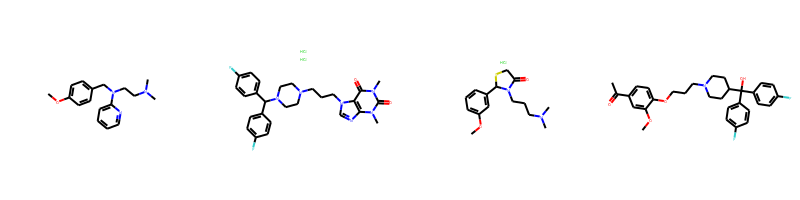

In [5]:
Draw.MolsToGridImage(df['mol'].values[:4], molsPerRow=4)

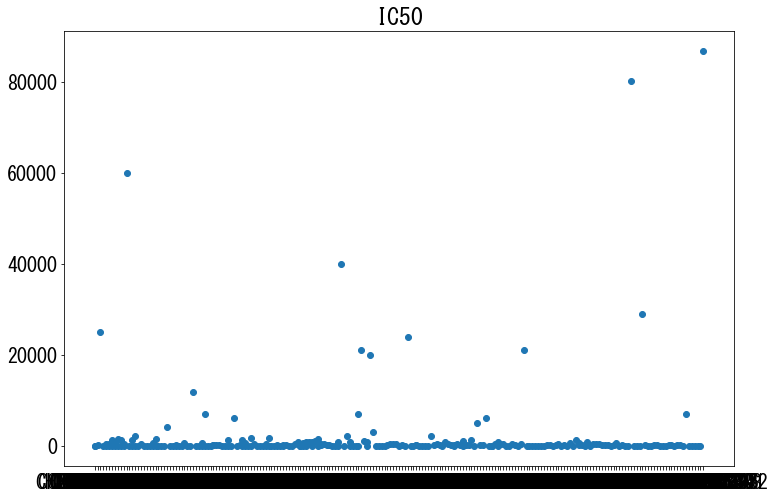

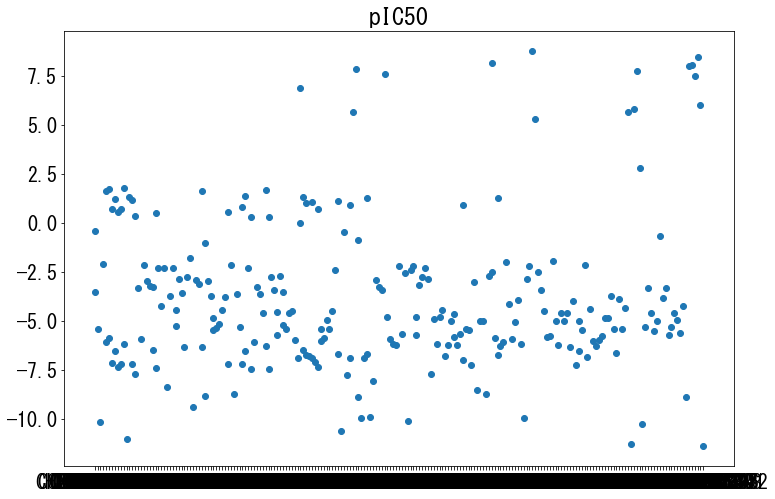

In [6]:
plt.plot(df['Standard Value'], 'o')
plt.title('IC50')
plt.show()

df['pIC50'] = -np.log(df['Standard Value'])
plt.plot(df['pIC50'], 'o')
plt.title('pIC50')
plt.show()

### pIC50によるクラス分け

低IC50(inhibitory concentration, IC)、すなわち高pIC50($=-{\rm log}IC_{50}$)のものほど
阻害剤としての性能が高いことを示す。

pIC50の上位50%を正例とした

In [7]:
is_inhibitor = df['pIC50']>=df['pIC50'].quantile(.5)
df['IS_INHIBITOR'] = is_inhibitor
df['CLASS']=df['IS_INHIBITOR'].astype(np.int)

In [8]:
df_train, df_test = train_test_split(df, test_size=.33, random_state=31415926, stratify=df['CLASS'])

In [9]:
ytrain = df_train['CLASS']
ytest  = df_test['CLASS']

### RDKit記述子

In [10]:
params = {'gamma': 2.**np.arange(-10,11),
          'C': 2.**np.arange(-10,11)}

calc_rd = RDKitDescriptor()
model_rd = GridSearchCV(SVC(), params, cv=3)
Xtrain = calc_rd.fit_transform(df_train['mol'])
Xtest = calc_rd.transform(df_test['mol'])
model_rd.fit(Xtrain, ytrain)
ycalc = model_rd.predict(Xtrain)
ypred = model_rd.predict(Xtest)
for name, yo, yp in zip(['train', 'test'], [ytrain, ytest], [ycalc, ypred]):
    print(name, '{:.3f}'.format(metrics.f1_score(yo, yp)))

train 0.920
test 0.582


In [11]:
jl_dump(model_rd, '../models/rdkit_svm.joblib')
del model_rd
gc.collect()

24

### Morganフィンガープリントとタニモトカーネル

`Pipeline`と`GridSearchCV`を使ってパラメータ探索する

In [12]:
def jaccard(u,v):
    """構造の有無にまるめて判定。フラグメントカウントは扱えない"""
    return np.sum(np.logical_and(np.array(u), np.array(v)))/np.sum(np.logical_or(np.array(u), np.array(v)))

def jaccard_bulk(X, Y):
    return cdist(X, Y, metric=jaccard)

In [13]:
# 試し書き
svm_tani = Pipeline([('morgan', HashedMorgan(n_bits=512,radius=3)),
                     ('svm', SVC(kernel=jaccard_bulk))])
svm_tani.fit(df_train['mol'], ytrain)

ycalc = svm_tani.predict(df_train['mol'])
ypred = svm_tani.predict(df_test['mol'])
for name, yo, yp in zip(['train', 'test'], [ytrain, ytest], [ycalc, ypred]):
    print(name, '{:.3f}'.format(metrics.f1_score(yo, yp)))

train 0.856
test 0.696


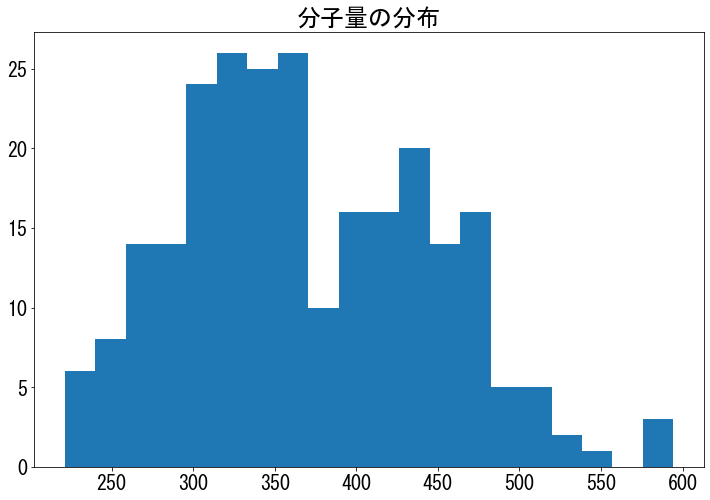

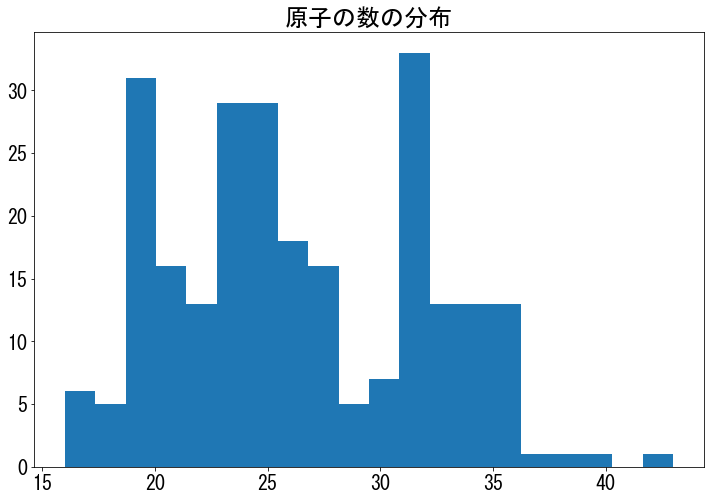

In [24]:
plt.hist(list(map(dict(Chem.Descriptors.descList)['MolWt'], df['mol'])), bins=20)
plt.title('分子量の分布')
plt.savefig('../results/10.4-chembl-molwt.jpg')
plt.show()
plt.hist(list(map(lambda m:len(m.GetAtoms()), df['mol'])), bins=20)
plt.title('原子の数の分布')
plt.savefig('../results/10.4-chembl-n_atoms.jpg')
plt.show()

In [15]:
params_mo = {'svm__C': 2.**np.arange(-8, 9),
             'morgan__n_bits': 2**np.arange(4,11),
             'morgan__radius': np.arange(3,6)}

pipe = Pipeline([('morgan', HashedMorgan(n_bits=512,radius=3)),
                     ('svm', SVC(kernel=jaccard_bulk))])
svm_tani = GridSearchCV(pipe, params_mo, cv=3)
%time svm_tani.fit(df_train['mol'], ytrain)

ycalc = svm_tani.predict(df_train['mol'])
ypred = svm_tani.predict(df_test['mol'])


for name, yo, yp in zip(['train', 'test'], [ytrain, ytest], [ycalc, ypred]):
    print(name, '{:.3f}'.format(metrics.f1_score(yo, yp)))

Wall time: 15min 35s
train 0.706
test 0.738


In [16]:
jl_dump(svm_tani, '../models/morgan_svm.joblib')
del svm_tani
gc.collect()

7404

### RDKitフィンガープリント

In [17]:
params_rdfrag = {'svm__C': 2.**np.arange(-8, 9),
             'rdfrag__n_bits': 2**np.arange(4,11),
             'rdfrag__fraglen': np.arange(3,8)}
pipe2 = Pipeline([('rdfrag', RDKitFingerprint()),
                  ('svm', SVC(kernel=jaccard_bulk))])

svm_rdtani = GridSearchCV(pipe2, params_rdfrag, cv=3)
%time svm_rdtani.fit(df_train['mol'], ytrain)

ycalc = svm_rdtani.predict(df_train['mol'])
ypred = svm_rdtani.predict(df_test['mol'])

for name, yo, yp in zip(['train', 'test'], [ytrain, ytest], [ycalc, ypred]):
    print(name, '{:.3f}'.format(metrics.f1_score(yo, yp)))

Wall time: 35min 17s
train 0.655
test 0.659


In [18]:
jl_dump(svm_rdtani, '../models/rdfrags_svm.joblib')
del svm_rdtani
gc.collect()

24

### スコアとモデルパラメータ

In [23]:
from joblib import load
from glob import glob 
for modelpath in glob('../models/*_svm.joblib'):
    m = load(modelpath)
    print(modelpath.replace('../models\\',''), '%.3f'%m.best_score_, m.best_params_)

morgan_svm.joblib 0.643 {'morgan__n_bits': 64, 'morgan__radius': 4, 'svm__C': 1.0}
rdfrags_svm.joblib 0.607 {'rdfrag__fraglen': 3, 'rdfrag__n_bits': 128, 'svm__C': 0.00390625}
rdkit_svm.joblib 0.512 {'C': 1.0, 'gamma': 0.0009765625}


#### 記述子ごとのF1-score

|    |train|cv|test|
|:---|:---|:---|:---|
|rdkit_svm|0.920|0.512 |0.582|
|morgan_svm|0.706|0.643 |0.738|
|rdfrags_svm|0.655|0.607 |0.659| 

### REFERENCES: `sklearn.svm.SVC`で自作カーネル関数を導入する例

- [Documentation](https://scikit-learn.org/stable/modules/svm.html#using-python-functions-as-kernels)
- [Example](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html#svm-with-custom-kernel)